In [1]:
import pandas as pd #type:ignore
import numpy as np #type:ignore
import matplotlib.pyplot as plt #type:ignore

from sklearn.linear_model import LinearRegression #type:ignore
from sklearn.preprocessing import MinMaxScaler #type:ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #type:ignore

In [2]:
store_sales = pd.read_csv("data.csv")
store_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Check for Null values in the dataset

In [3]:
store_sales.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

Dropping store and item colums

In [4]:
store_sales.drop(["store", "item"], axis = 1, inplace= True)

Converting date from object datatype to dateTime datatype

In [5]:
store_sales["date"] = pd.to_datetime(store_sales["date"])

Converting date to a Month period and then sum the number of items in each month

In [6]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

Convert the resulting date to timestamp datatype

In [7]:
monthly_sales["date"] = monthly_sales["date"].dt.to_timestamp()

In [8]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Visualisation

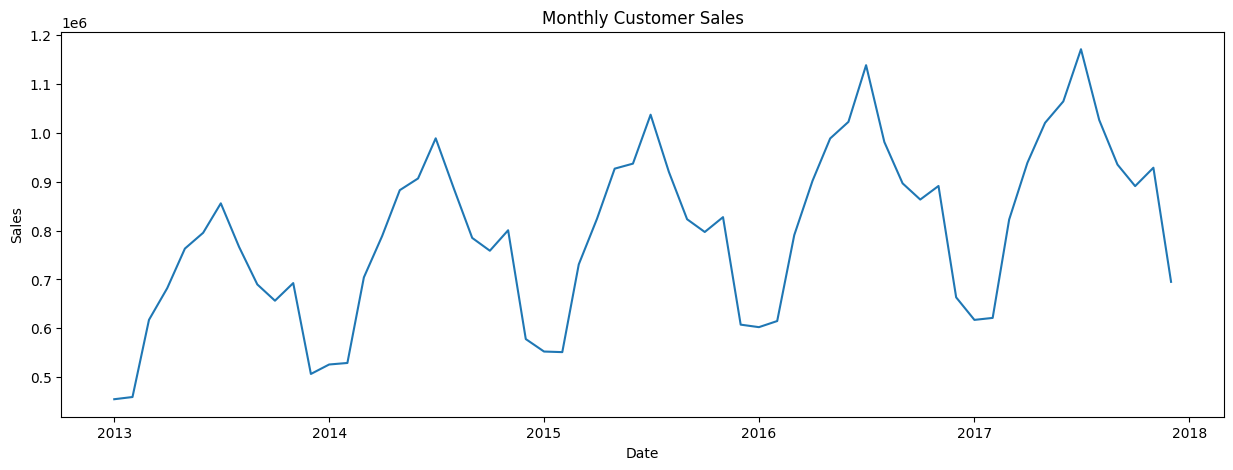

In [9]:
plt.figure(figsize = (15, 5))
plt.plot(monthly_sales.date , monthly_sales.sales)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

Call the difference on the sales columns to make the sales data stationary

In [10]:
monthly_sales["Sales_diff"] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()

,date,sales,Sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


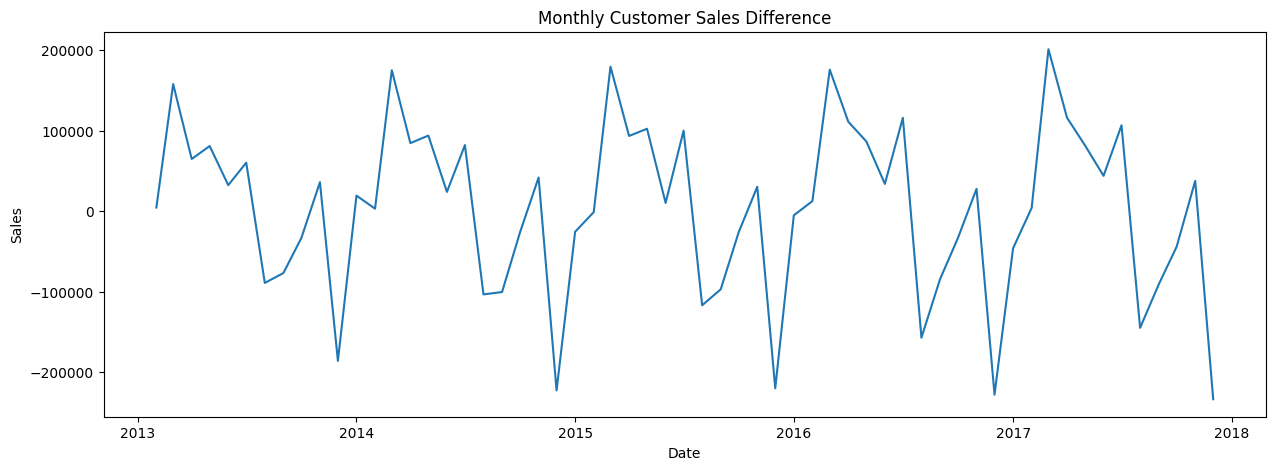

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['Sales_diff'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Difference")
plt.show()

Dropping of sales and date

In [12]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis = 1)

Preparing the supervised data

In [13]:
for i in range(1, 13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['Sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop = True)
supervised_data.head()

,Sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


Split the data into Train and Test

In [14]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print(f"Train data shape {train_data.shape}.")
print(f"Test data shape {test_data.shape}.")

Train data shape (35, 13).
Test data shape (12, 13).


In [15]:
scalar = MinMaxScaler(feature_range=(-1, 1))
scalar.fit(train_data)
train_data = scalar.transform(train_data)
test_data = scalar.transform(test_data)

In [16]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print(f"X_train shape: {x_train.shape}")
print(f"Y_train shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"Y_test shape: {y_test.shape}")

X_train shape: (35, 12)
Y_train shape: (35,)
X_test shape: (12, 12)
Y_test shape: (12,)


Make prediction data frame to merge the predicted sales prices of all trained algorithms

In [17]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [18]:
act_Sales = monthly_sales['sales'][-13:].to_list()
print(act_Sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


To create the linear regression model and predicted output

In [19]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_prediction = lr_model.predict(x_test)

In [20]:
lr_prediction = lr_prediction.reshape(-1, 1)
# This is a set matrix - contains the input features of the test data and also the predicted output
lr_pre_test_set = np.concatenate([lr_prediction, x_test], axis=1)
lr_pre_test_set = scalar.inverse_transform(lr_pre_test_set)

In [21]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_Sales[index])

lr_pre_Series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_Series, left_index = True, right_index = True)

In [22]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])


print(f"Linear Regression MSE: {lr_mse}")
print(f"Linear Regression MAE: {lr_mae}")
print(f"Linear Regression R2 score: {lr_r2}")


Linear Regression MSE: 16221.272385416883
Linear Regression MAE: 12433.184266490754
Linear Regression R2 score: 0.9906152516380969


Visualization of the prediction against the actual series

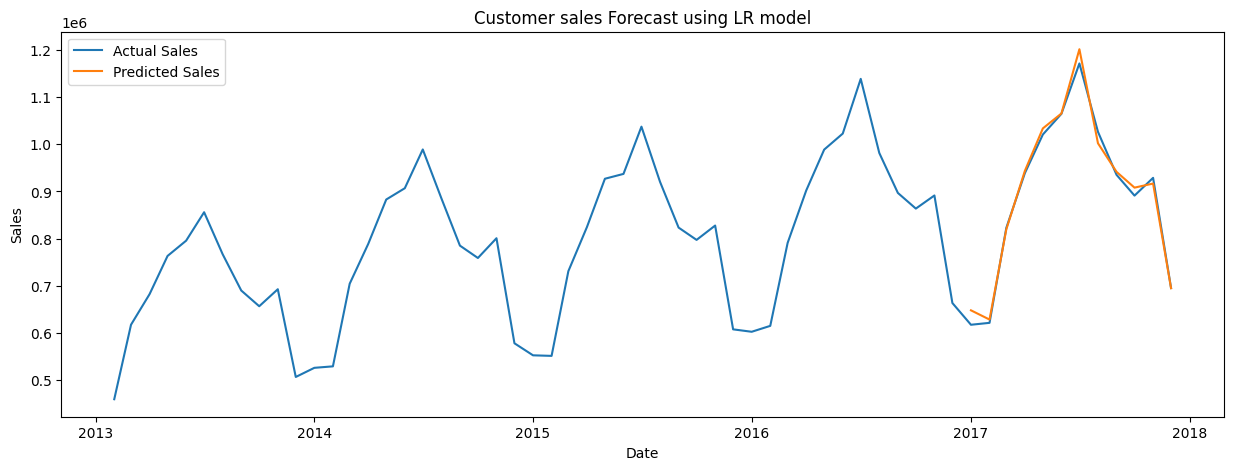

In [23]:
plt.figure(figsize=(15, 5))
# Actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer sales Forecast using LR model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()